# Bring your own custom drift detector with Amazon SageMaker Model Monitor

This notebook shows how to:

* Host a machine learning model in Amazon SageMaker and capture inference requests, results, and metadata
* Build a Docker container to include your custom drift algorithms
* Monitor a live endpoint for detecting drifts
* Visualize the drift results

## Background

Amazon SageMaker provides every developer and data scientist with the ability to build, train, and deploy machine learning models quickly. Amazon SageMaker is a fully-managed service that encompasses the entire machine learning workflow. You can label and prepare your data, choose an algorithm, train a model, and then tune and optimize it for deployment. You can deploy your models to production with Amazon SageMaker to make predictions and lower costs than was previously possible.

In addition, Amazon SageMaker enables you to capture the input, output and metadata for invocations of the models that you deploy. It also enables you to bring your own metrics to analyze the data and monitor its quality. In this notebook, you learn how Amazon SageMaker enables these capabilities.

## Setup

To get started, make sure you have these prerequisites completed.

* Specify an AWS Region to host your model.
* An IAM role ARN exists that is used to give Amazon SageMaker access to your data in Amazon Simple Storage Service (Amazon S3). See the documentation for how to fine tune the permissions needed.
* Create an S3 bucket used to store the data used to train your model, any additional model data, and the data captured from model invocations. For demonstration purposes, you are using the same bucket for these. In reality, you might want to separate them with different security policies.

In [1]:
# Handful of configuration

import os
import boto3
import json
from sagemaker import get_execution_role, session

region= boto3.Session().region_name

sm_client = boto3.client('sagemaker')

role = get_execution_role()
print("RoleArn: {}".format(role))

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the data is captured
bucket =  session.Session(boto3.Session()).default_bucket()
print("Demo Bucket: {}".format(bucket))
prefix = 'sagemaker/DEMO-ModelMonitor'

s3_capture_upload_path = f's3://{bucket}/{prefix}/datacapture'
s3_report_path = f's3://{bucket}/{prefix}/reports'

print("Capture path: {s3_capture_upload_path}")
print("Report path: {s3_report_path}")

RoleArn: arn:aws:iam::179065836194:role/service-role/AmazonSageMaker-ExecutionRole-20200822T180839
Demo Bucket: sagemaker-us-west-2-179065836194
Capture path: s3://sagemaker-us-west-2-179065836194/sagemaker/DEMO-ModelMonitor/datacapture
Report path: s3://sagemaker-us-west-2-179065836194/sagemaker/DEMO-ModelMonitor/reports


### Upload train and test datasets, and model file to S3

The dataset is taken from [UCI Census Income Data Set](https://archive.ics.uci.edu/ml/datasets/adult). The task is to predict whether income exceeds $50K/yr based on census data. We have split the dataset into train and test datasets. The model was trained using XGBoost and the model file is provided here. 

We need test datasets for calculating projected accuracy.

In [75]:
model_file = open("model/model.tar.gz", 'rb')
train_file = open("data/train.csv", 'rb')
test_file = open("data/test.csv", 'rb')

s3_model_key = os.path.join(prefix, 'model.tar.gz')
s3_train_key = os.path.join(prefix, 'train.csv')
s3_test_key = os.path.join(prefix, 'test.csv')

boto3.Session().resource('s3').Bucket(bucket).Object(s3_model_key).upload_fileobj(model_file)
boto3.Session().resource('s3').Bucket(bucket).Object(s3_train_key).upload_fileobj(train_file)
boto3.Session().resource('s3').Bucket(bucket).Object(s3_test_key).upload_fileobj(test_file)

print("Success! You are all set to proceed.")

## Bring your own custom model drift detection algorithm

In order to bring your own custom model drift detection algorithm, you need to do following things:
* Create custom detection algorithms. We have included algorithms under src folder
* Create a Docker container.
* Set enviornmental variables where the container can find the datacapture data from SageMaker Model Monitor. These variables have to match with the values we provide to monitor scheduler later.

In [1]:
!pygmentize Dockerfile

FROM python:3.8-slim-buster

RUN pip3 install pandas==1.1.4 numpy==1.19.4 scikit-learn==0.23.2 pyarrow==2.0.0 scipy==1.5.4 boto3==1.17.12

WORKDIR /home

COPY src/* /home/

ENTRYPOINT ["python3", "drift_detector.py"]


### Build the container and upload it to ECR

In [144]:
from docker_utils import build_and_push_docker_image

repository_short_name = 'custom-model-monitor'

image_name = build_and_push_docker_image(repository_short_name)

Building docker image custom-model-monitor from Dockerfile
$ docker build -t custom-model-monitor -f Dockerfile .
Sending build context to Docker daemon  56.87MB
Step 1/5 : FROM python:3.8-slim-buster
 ---> 13172ea67a56
Step 2/5 : RUN pip3 install pandas==1.1.4 numpy==1.19.4 scikit-learn==0.23.2 pyarrow==2.0.0 scipy==1.5.4 boto3==1.17.12
 ---> Using cache
 ---> 6f1898c9406a
Step 3/5 : WORKDIR /home
 ---> Using cache
 ---> 8b8c1732f3f3
Step 4/5 : COPY src/* /home/
 ---> d1d8e68e43cc
Step 5/5 : ENTRYPOINT ["python3", "drift_detector.py"]
 ---> Running in 48e6facac0e8
Removing intermediate container 48e6facac0e8
 ---> e3d9c031802e
Successfully built e3d9c031802e
Successfully tagged custom-model-monitor:latest
Done building docker image custom-model-monitor
ECR repository already exists: custom-model-monitor
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential

## Setup endoint and enable data capture

The data that is sent for inference to the endpoint needs to pre-processed before the XGBoost model can do prediction. Below code shows custom input handler for inference endpoint.

In [76]:
!pygmentize script/inference.py

#  Copyright 2020 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
#  Licensed under the Apache License, Version 2.0 (the "License").
#  You may not use this file except in compliance with the License.
#  A copy of the License is located at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  or in the "license" file accompanying this file. This file is distributed
#  on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
#  express or implied. See the License for the specific language governing
#  permissions and limitations under the License.

import os
import pickle
import pathlib

from io import StringIO

import numpy as np
import pandas as pd

import sagemaker_xgboost_container.encoder as xgb_encoders


script_path = pathlib.Path(__file__).parent.absolute()
with open(f'{script_path}/preprocess.pkl', 'rb') as f:
    preprocess = pickle.load(f) 


def input_fn(request_body, content_type):
    """
    The SageMaker XGBoost model server receives the re

### Setting up model endpoint can take few minutes.

In [22]:
from sagemaker.xgboost.model import XGBoostModel
from sagemaker.serializers import CSVSerializer
from sagemaker.model_monitor import DataCaptureConfig

model_url = f's3://{bucket}/{s3_model_key}'

xgb_inference_model = XGBoostModel(
    model_data=model_url,
    role=role,
    entry_point='inference.py',
    source_dir='script',
    framework_version='1.2-1',
)

data_capture_config = DataCaptureConfig(
                        enable_capture=True,
                        sampling_percentage=100,
                        destination_s3_uri=s3_capture_upload_path)

predictor = xgb_inference_model.deploy(
    initial_instance_count=1,
    instance_type="ml.c5.xlarge",
    serializer=CSVSerializer(),
    data_capture_config=data_capture_config)

---------------!

## Create monitoring schedule to detect drifts on hourly basis

Default Model monitor can be setup to monitor the inference on an hourly basis against the baseline metrics and violations. In this example, we are setting custom model monitor. For this purpose, we are using Boto3 calls directly to setup model monitor with the container we built above. Note that we need to setup input and output paths on the container. 

In [151]:
s3_train_path = f's3://{bucket}/{s3_train_key}'
s3_test_path = f's3://{bucket}/{s3_test_key}'
s3_result_path = f's3://{bucket}/{prefix}/result/{predictor.endpoint_name}'

sm_client.create_monitoring_schedule(
    MonitoringScheduleName=predictor.endpoint_name,
    MonitoringScheduleConfig={
        'ScheduleConfig': {
            'ScheduleExpression': 'cron(0 * ? * * *)'
        },
        'MonitoringJobDefinition': {
            'MonitoringInputs': [
                {
                    'EndpointInput': {
                        'EndpointName': predictor.endpoint_name,
                        'LocalPath': '/opt/ml/processing/endpointdata'
                    }
                },
            ],
            'MonitoringOutputConfig': {
                'MonitoringOutputs': [
                    {
                        'S3Output': {
                            'S3Uri': s3_result_path,
                            'LocalPath': '/opt/ml/processing/resultdata',
                            'S3UploadMode': 'EndOfJob'
                        }
                    },
                ]
            },
            'MonitoringResources': {
                'ClusterConfig': {
                    'InstanceCount': 1,
                    'InstanceType': 'ml.c5.xlarge',
                    'VolumeSizeInGB': 10
                }
            },
            'MonitoringAppSpecification': {
                'ImageUri': image_name,
                'ContainerArguments': [
                    '--train_s3_uri',
                    s3_train_path,
                    '--test_s3_uri',
                    s3_test_path,
                    '--target_label',
                    'income'
                ]
            },
            'StoppingCondition': {
                'MaxRuntimeInSeconds': 600
            },
            'Environment': {
                'string': 'string'
            },
            'RoleArn': role
        }
    }
)

{'MonitoringScheduleArn': 'arn:aws:sagemaker:us-west-2:179065836194:monitoring-schedule/sagemaker-xgboost-2021-02-24-16-55-04-100',
 'ResponseMetadata': {'RequestId': 'a847881e-6f7b-4e7d-a707-a270bb61cbc7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a847881e-6f7b-4e7d-a707-a270bb61cbc7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Sat, 27 Feb 2021 09:12:53 GMT'},
  'RetryAttempts': 0}}

Finished sending 750 records.


## Start sending pre-configured traffic to endpoint

The cell below starts a thread to send some pre-configured traffic at a constant rate to the endpoint. The data points have been pre-conditioned to have drift, so that we can visualize it later. The traffic is sent for about 10 hours. If you like to stop the traffic, you need to stop the kernel to terminate this thread. 

In [166]:
from threading import Thread
from time import time, sleep

def invoke_endpoint(ep_name, file_name, runtime_client):
    pre_time = time()
    with open(file_name) as f:
        count = len(f.read().split('\n')) - 2 # Remove EOF and header
    
    # Calculate time needed to sleep between inference calls if we need to have a constant rate of calls for 10 hours
    ten_hours_in_sec = 10*60*60
    sleep_time = ten_hours_in_sec/count
    
    with open(file_name, 'r') as f:
        next(f) # Skip header
        
        for ind, row in enumerate(f):   
            start_time = time()
            payload = row.rstrip('\n')
            response = runtime_client(data=payload)
            
            # Print every 15 minutes (900 seconds)
            if (ind+1) % int(count/ten_hours_in_sec*900) == 0:
                print(f'Finished sending {ind+1} records.')
            
            # Sleep to ensure constant rate. Time spent for inference is subtracted
            sleep(max(sleep_time - (time() - start_time), 0))
                
    print("Done!")
    
print(f"Sending test traffic to the endpoint {predictor.endpoint_name}. \nPlease wait...")

thread = Thread(target = invoke_endpoint, args=(predictor.endpoint, 'data/infer.csv', predictor.predict))
thread.start()

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Sending test traffic to the endpoint sagemaker-xgboost-2021-02-24-16-55-04-100. 
Please wait...


## Visualization

Here we provide several visualizations to capture model drift. The plots are launched in threads so that they can refesh plots automatically every hour.

In [160]:
%load_ext autoreload

%autoreload 1

import sys
from threading import Timer

sys.path.append('src')

%aimport drift_visualizer
%aimport utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Projected accuracy

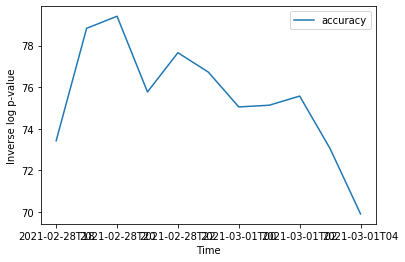

In [182]:
def plot_accuracy():
    df = utils.construct_df_from_result(s3_result_path)
    if df is not None:    
        drift_visualizer.plot_accuracy(df)
    Timer(3600, plot_accuracy)
    
plot_accuracy()

### Normalized feature drift scores

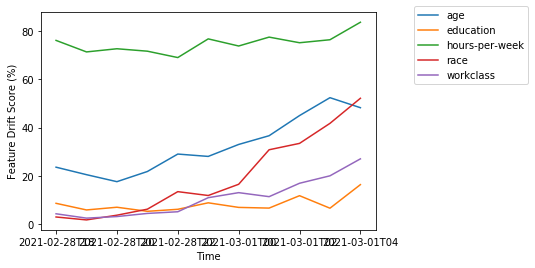

In [181]:
def plot_drift_score():
    df = utils.construct_df_from_result(s3_result_path) 
    if df is not None:    
        drift_visualizer.plot_drift_score(df)
    Timer(3600, plot_drift_score)
    
plot_drift_score()

### Null hypothesis of features (based on p-values)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


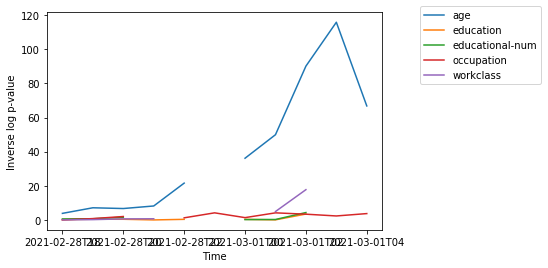

In [180]:
def plot_p_values():
    df = utils.construct_df_from_result(s3_result_path)   
    if df is not None:            
        drift_visualizer.plot_p_values(df)
    Timer(3600, plot_p_values)
    
plot_p_values()

## Clean up resources
* Monitor schedule - needs to deleted before deleting endpoint
* Delete endpoint
* Delete model

In [ ]:
sm_client.delete_monitoring_schedule(MonitoringScheduleName=predictor.endpoint)

# predictor.delete_endpoint()
# predictor.delete_model()